In [1]:
# Requires R kernel
# Planned companion using Python & PyMC3 instead of R, Stan, and rethinking library.
library(data.table)
library(rethinking)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.85)


In [2]:
options(mc.cores = parallel::detectCores())

In [3]:
setwd('~/go_nuts/')

In [4]:
# Load trials data
trials1 = fread('~/go_nuts/trials022319.csv', 
            sep = '\t',
            header = FALSE,
            col.names = c('start', 'surface', 'outcome'))
trials2 = fread('~/go_nuts/trials022409.csv',
                sep = '\t',
                header = FALSE,
                col.names = c('start', 'surface', 'outcome'))
trials3 = fread('~/go_nuts/trials022519.csv',
                sep = '\t',
                header = FALSE,
                col.names = c('start', 'surface', 'outcome'))
trials4 = fread('~/go_nuts/trials02271408.csv',
                sep = '\t',
                header = FALSE,
                col.names = c('start', 'surface', 'outcome'))
cat('trials1:\n')
trials1[, .N, by = .(start, surface, outcome)]
cat('trials2:\n')
trials2[, .N, by = .(start, surface, outcome)]
cat('trials3:\n')
trials3[, .N, by = .(start, surface, outcome)]
cat('trials4:\n')
trials4[, .N, by = .(start, surface, outcome)]

trials = rbind(
  trials1, 
  trials2, 
  trials3, 
  trials4
)
cat('all trials:\n')
trials[, .N, by = .(start, surface)]

trials1:


start,surface,outcome,N
H,S,H,27
T,S,T,25
T,C,T,23
H,C,H,25
H,S,T,24
H,C,T,27
T,S,H,24
T,C,H,25


trials2:


start,surface,outcome,N
H,S,T,97
H,S,H,103


trials3:


start,surface,outcome,N
H,C,T,61
H,C,H,42
T,C,H,58
T,C,T,49
H,S,H,107
H,S,T,88
T,S,T,95
T,S,H,102


trials4:


start,surface,outcome,N
T,S,H,107
T,S,T,101


all trials:


start,surface,N
H,S,446
T,S,454
T,C,155
H,C,155


In [5]:
# Add derived outcome, wherever it equals the start
trials[, outcome_eq_start := as.integer(outcome == start)]
cat('Table on outcome_eq_start:\n')
trials[, .N, by = outcome_eq_start]

Table on outcome_eq_start:


outcome_eq_start,N
1,597
0,613


In [6]:
# Add 0/1 columns for boolean variables:
trials[, start_h := as.integer(start == 'H')]
trials[, surface_c := as.integer((surface == 'C'))]
trials[, outcome_h := as.integer(outcome == 'H')]
print(head(trials))

   start surface outcome outcome_eq_start start_h surface_c outcome_h
1:     H       S       H                1       1         0         1
2:     T       S       T                1       0         0         0
3:     T       C       T                1       0         1         0
4:     H       C       H                1       1         1         1
5:     H       S       T                0       1         0         0
6:     T       S       T                1       0         0         0


In [7]:
d <- trials

In [8]:
# Must convert to integer so Stan can treat properly:
# stone,tails ; stone,heads ; cloth,tails ; cloth,heads
d$treatment <- as.integer(1 + d$start_h + 2*d$surface_c)
head(d)

start,surface,outcome,outcome_eq_start,start_h,surface_c,outcome_h,treatment
H,S,H,1,1,0,1,2
T,S,T,1,0,0,0,1
T,C,T,1,0,1,0,3
H,C,H,1,1,1,1,4
H,S,T,0,1,0,0,2
T,S,T,1,0,0,0,1


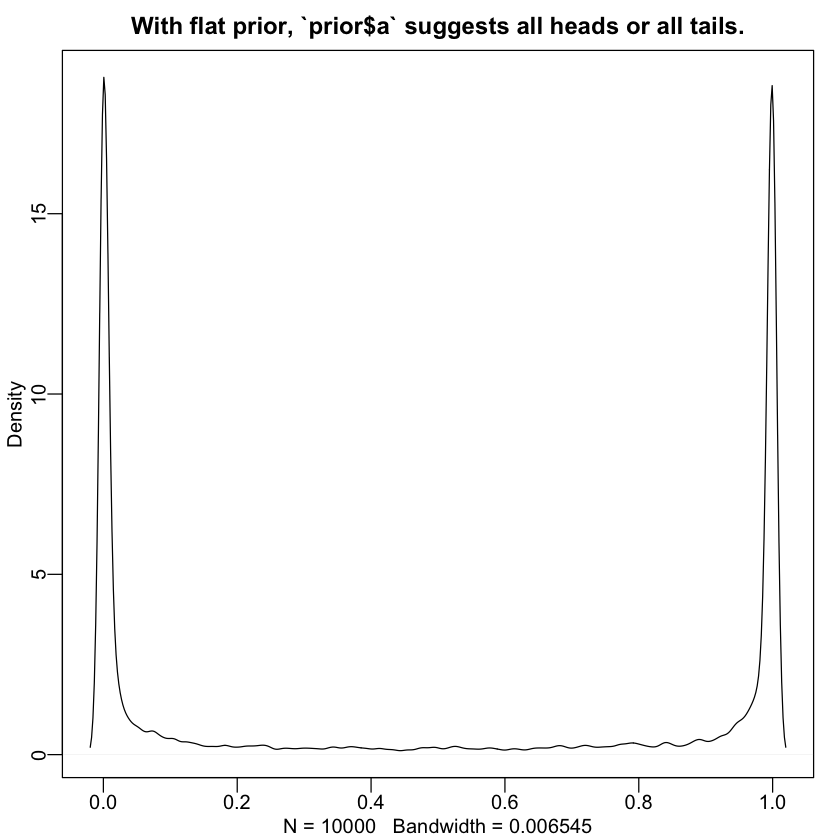

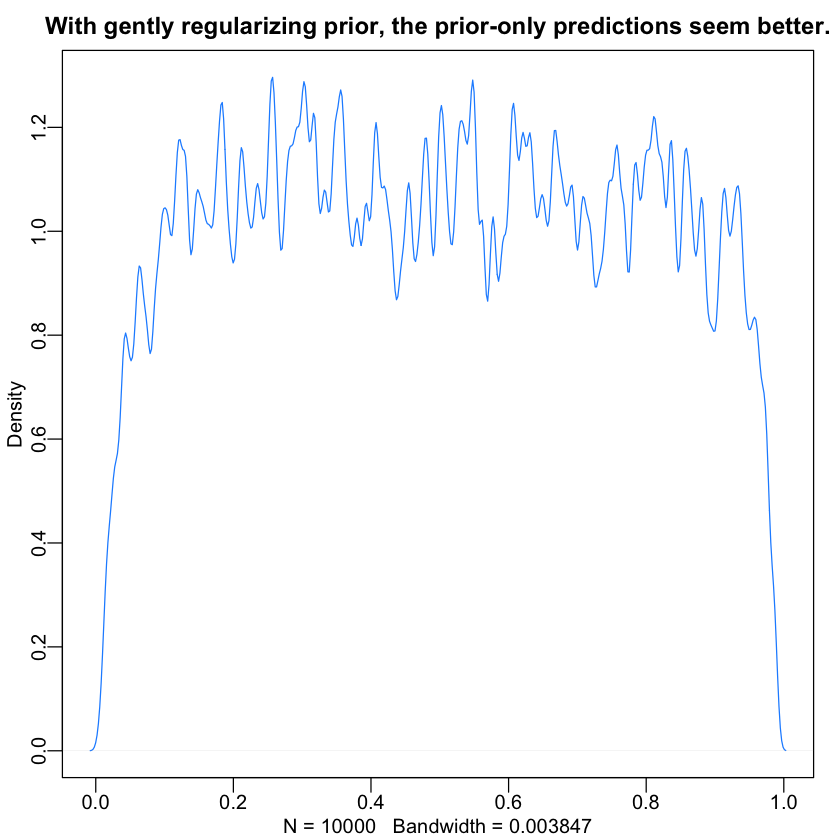

In [9]:
# Try a very flat prior on the intercept, a:
m11.1coin_flatprior <- quap(
    alist(
        outcome_h ~ dbinom(1, p),
        logit(p) <- a,
        a ~ dnorm(0, 10)
    ),
    data = d
)
set.seed(1999)
prior <- extract.prior(m11.1coin_flatprior, n = 1e4)

p <- inv_logit(prior$a)

dens(p, adj=0.1, main = 'With flat prior, `prior$a` suggests all heads or all tails.')

# With a regularizing prior, we encode the information that even an adulterated coin has p
# centered around .5 -- it has the side-effect of making the sampler much more efficient, later.
m11.1coin <- quap(
    alist(
        outcome_h ~ dbinom(1, p),
        logit(p) <- a,
        a ~ dnorm(0, 1.5)
    ),
    data = d
)
set.seed(1999)
prior <- extract.prior(m11.1coin, n = 1e4)

p <- inv_logit(prior$a)

dens(p, adj=0.1, main = 'With gently regularizing prior, the prior-only predictions seem better.', 
     col = 'dodgerBlue')

Number of treatments: 4

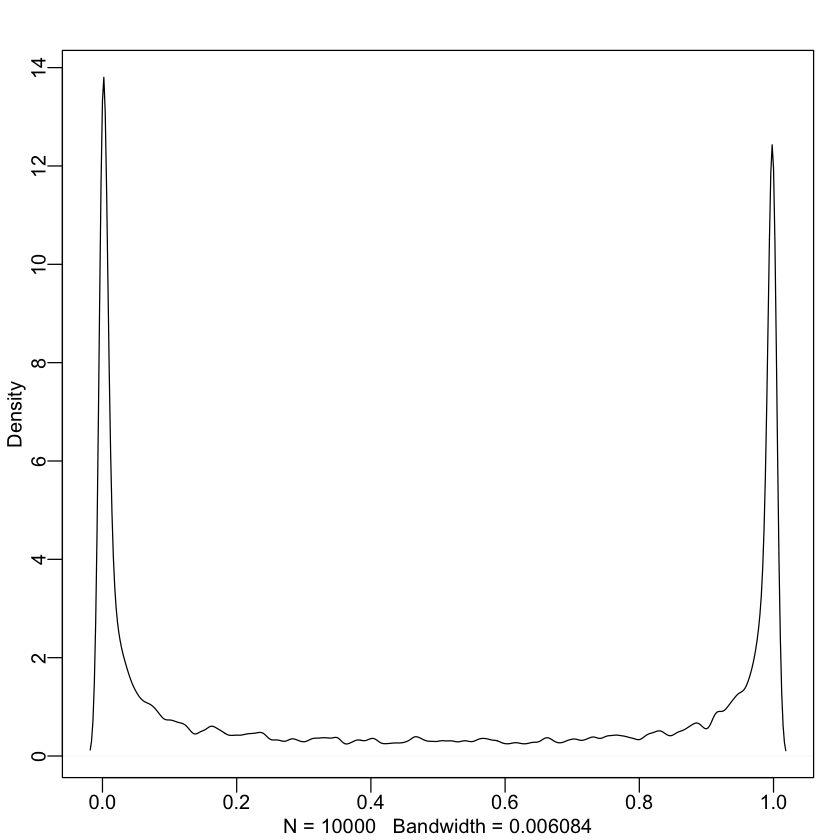

In [10]:
m11.2coin <- quap(
    alist(
        outcome_h ~ dbinom(1, p),
        logit(p) <- a + b[treatment],
        a ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 10)
    ),
    data = d
)
set.seed(1999)
prior <- extract.prior(m11.2coin, n = 1e4)
num_treatments = length(unique(d$treatment))
cat(paste('Number of treatments:', num_treatments))
p <- sapply(1:(num_treatments - 1), function(k) inv_logit(prior$a + prior$b[,k]))

dens(abs(p[,1] - p[,2]), adj = 0.1)

Number of treatments: 4

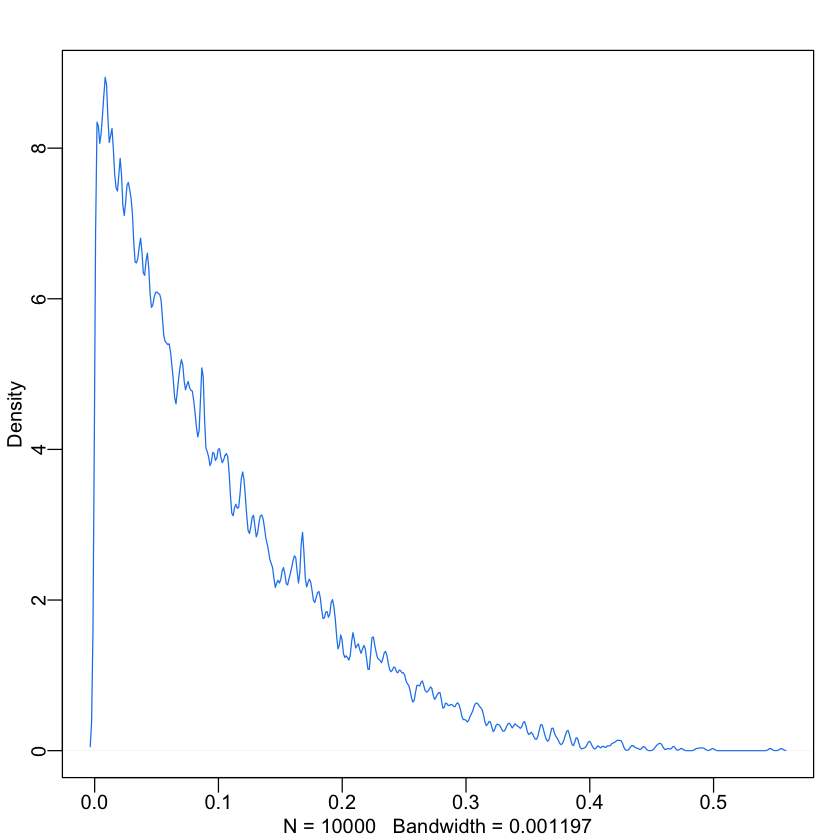

In [11]:
m11.3coin_better <- quap(
    alist(
        outcome_h ~ dbinom(1, p),
        logit(p) <- a + b[treatment],
        a ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, .5)
    ),
    data = d
)
set.seed(1999)
prior <- extract.prior(m11.3coin_better, n = 1e4)
num_treatments = length(unique(d$treatment))
cat(paste('Number of treatments:', num_treatments))
p <- sapply(1:(num_treatments - 1), function(k) inv_logit(prior$a + prior$b[,k]))

dens(abs(p[,1] - p[,2]), adj = 0.1, 'Treatment effects now regularized in the prior', 
     col = 'dodgerBlue2')

In [12]:
dat_list_simple <- list(
    outcome_h = d$outcome_h,
    surface_c = d$surface_c
)

In [13]:
# Fit the model with population effects only:
# a: intercept
# b: effect of tossing the coin oon
m11.4pop_only <- ulam(
    alist(
        outcome_h ~ dbinom(1, p),
        logit(p) <- a + b * surface_c,
        a ~ dnorm(0, 1.5),
        b ~ dnorm(0, .5)
    ),
    data = dat_list_simple, 
    chains = 4, iter = 5000, warmup = 1000, log_lik = TRUE
)



SAMPLING FOR MODEL '8001fdb9acac774c1b8f7e76894822df' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000198 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.98 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1001 / 5000 [ 20%]  (Sampling)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Sampling)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Sampling)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.922654 seconds (Warm-up)
Chain 1:                3.49215 seconds (Samp

,mean,sd,5.5%,94.5%,n_eff,Rhat
a,0.08790669,0.06696222,-0.01742324,0.19668882,7104.729,1.0000738
b,-0.14458164,0.12888643,-0.35235763,0.06040399,7553.532,0.9999707


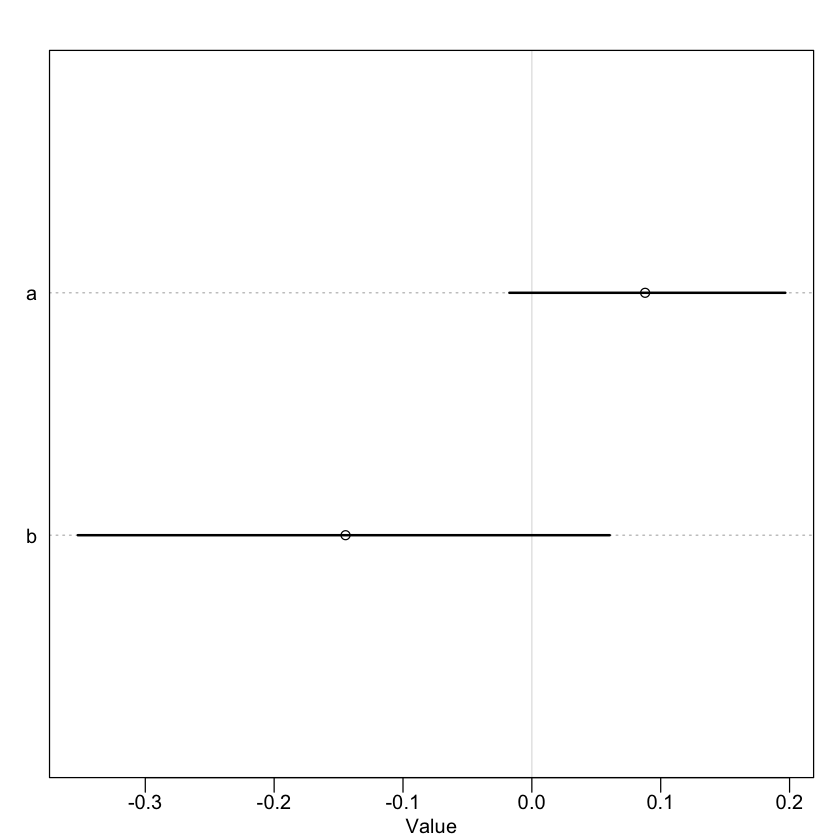

In [14]:
precis(m11.4pop_only, depth = 2)
plot(precis(m11.4pop_only, depth = 2))

In [15]:
show(m11.4pop_only)

Hamiltonian Monte Carlo approximation
16000 samples from 4 chains

Sampling durations (seconds):
        warmup sample total
chain:1   0.92   3.49  4.41
chain:2   0.98   3.47  4.45
chain:3   0.96   3.80  4.75
chain:4   0.97   3.99  4.95

Formula:
outcome_h ~ dbinom(1, p)
logit(p) <- a + b * surface_c1
a ~ dnorm(0, 1.5)
b ~ dnorm(0, 0.5)


In [16]:
post <- extract.samples(m11.4pop_only)
cat('Number of posterior samples:',length(post$a))
plen <- length(post$a)
zeros <- floor(length(post$a)/2)
surface_synth <- c(rep(0, zeros), rep(1, plen-zeros))

Number of posterior samples: 16000

In [17]:
p_heads <- inv_logit(post$a + post$b * surface_synth)

In [18]:
probs  <- list(
    surface_stone = inv_logit(post$a[surface_synth == 0] + 
                              post$b[surface_synth == 0] * surface_synth[surface_synth == 0]),
    surface_cloth = inv_logit(post$a[surface_synth == 1] + 
                              post$b[surface_synth == 1] * surface_synth[surface_synth == 1])  
)

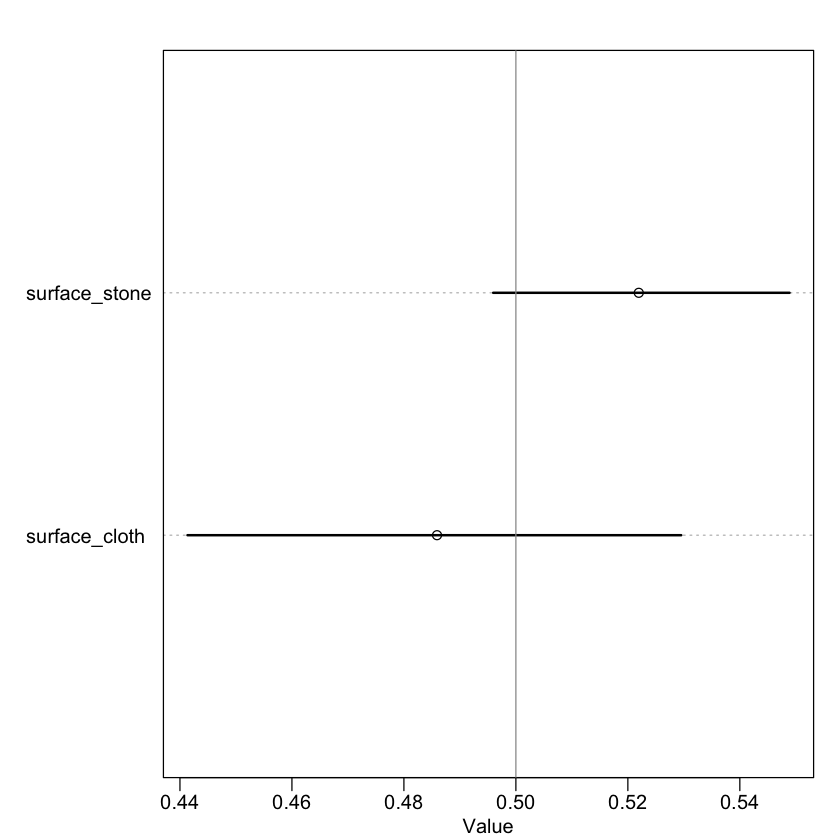

In [19]:
plot(precis(as.data.table(probs)), labels = names(probs))
abline(v = .5, col = 'gray60')

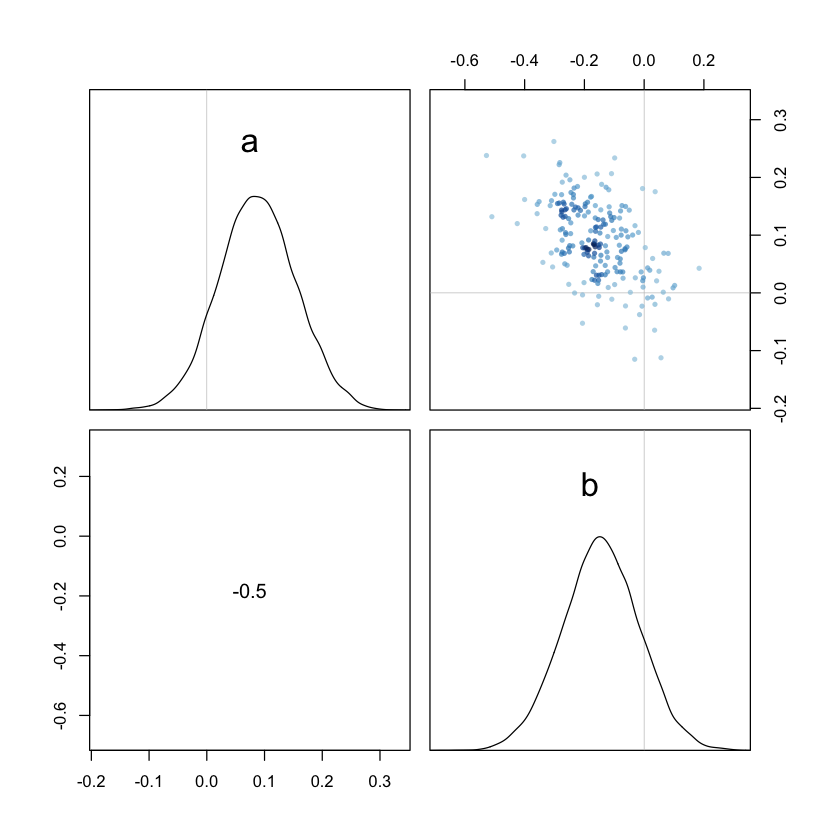

In [30]:
pairs(m11.4pop_only)

In [20]:
# PREPARE FOR MORE COMPLICATED MODEL
# prior trimmed data list
# Need surface column to also work as a subscript in R, 
# which means needs values from 1:2 not 0:1
dat_list <- list(
    outcome_h = d$outcome_h,
    surface_c1 = as.integer(d$surface_c + 1),
    treatment = d$treatment
)

In [21]:
# Particles in many-dimensional space:
# Sampling... for this case, this takes time to compile the model,
# offload it to Stan for external processing, and reload the results.
m11.4coin <- ulam(
    alist(
        outcome_h ~ dbinom(1, p),
        logit(p) <- a[surface_c1] + b[treatment],
        a[surface_c1] ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ),
    data = dat_list, 
    chains = 4, iter = 5000, warmup = 1000, log_lik = TRUE
)
precis(m11.4coin, depth = 2)


SAMPLING FOR MODEL '87f0f6a40b3f520aff7b8a44cf501fe3' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000183 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.83 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1001 / 5000 [ 20%]  (Sampling)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Sampling)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Sampling)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.91458 seconds (Warm-up)
Chain 1:                16.8146 seconds (Sampl

,mean,sd,5.5%,94.5%,n_eff,Rhat
a[1],0.08518112,0.3509811,-0.4794290,0.6427377,5551.798,1.000127
a[2],-0.06199573,0.3655134,-0.6421948,0.5216985,5920.202,1.000748
b[1],-0.03094074,0.3512546,-0.5833164,0.5309849,5678.585,1.000056
b[2],0.03924407,0.3515056,-0.5250397,0.6025092,5638.340,1.000090
b[3],0.18674254,0.3639956,-0.3931925,0.7675112,6222.276,1.000779
b[4],-0.19349043,0.3651948,-0.7732069,0.4022143,6163.334,1.000651


In [22]:
show(m11.4coin)

Hamiltonian Monte Carlo approximation
16000 samples from 4 chains

Sampling durations (seconds):
        warmup sample total
chain:1   3.91  16.81 20.73
chain:2   3.75  16.33 20.08
chain:3   3.93  15.60 19.53
chain:4   3.94  14.04 17.98

Formula:
outcome_h ~ dbinom(1, p)
logit(p) <- a[surface_c1] + b[treatment]
a[surface_c1] ~ dnorm(0, 1.5)
b[treatment] ~ dnorm(0, 0.5)


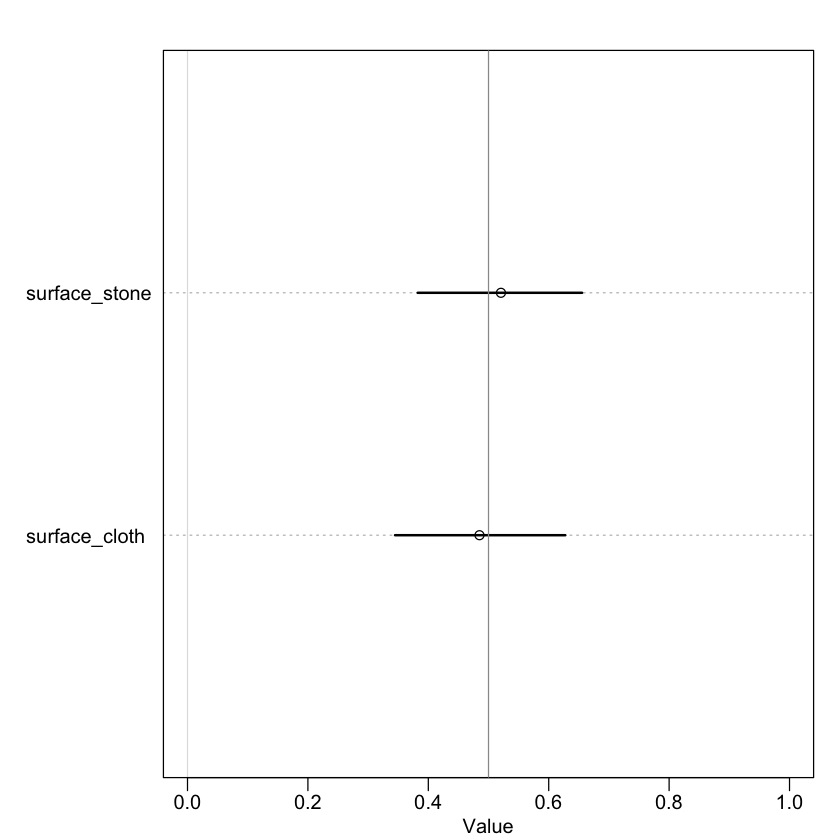

In [23]:
post <- extract.samples(m11.4coin)
p_heads <- inv_logit(post$a)
colnames(p_heads) <- c('surface_stone', 'surface_cloth')
plot(precis(as.data.frame(p_heads)), xlim = c(0,1))
abline(v = .5, col = 'gray60')

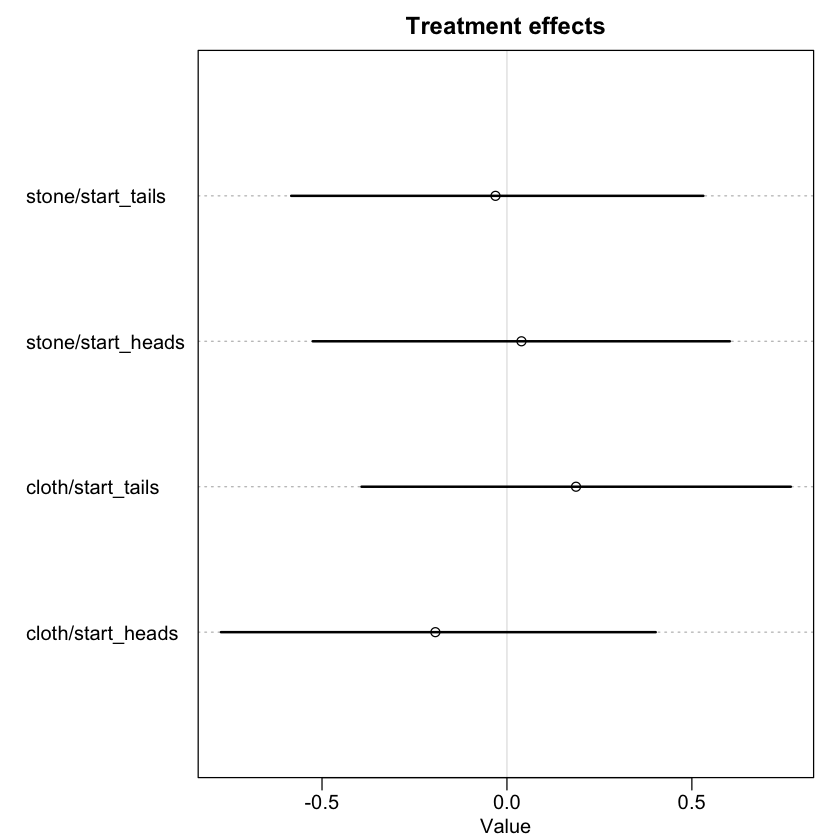

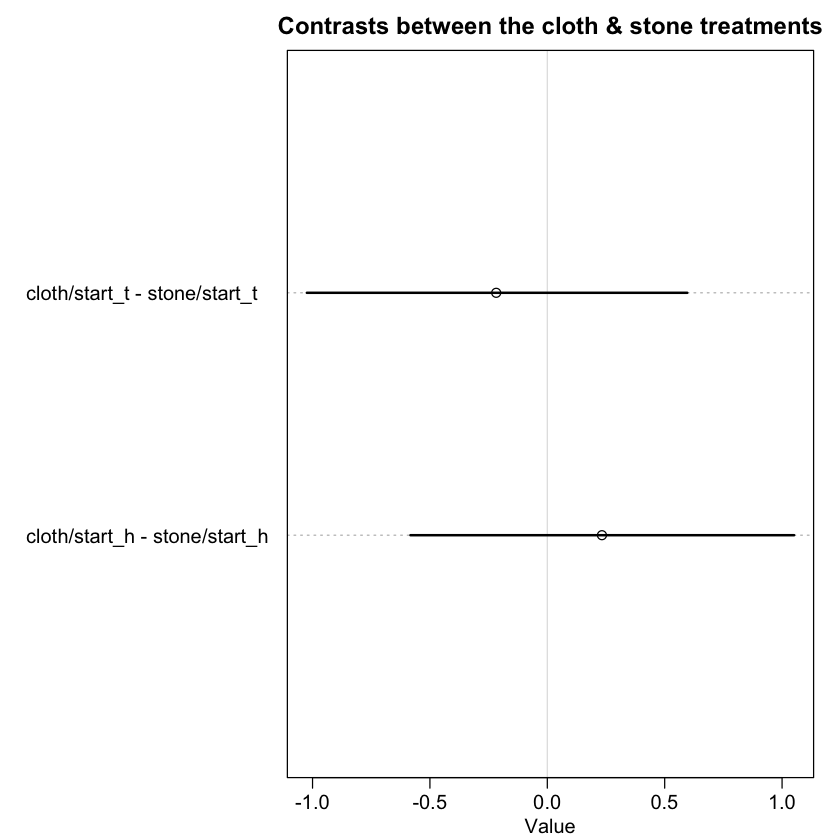

In [24]:
# 11.12 adapted
labs <- c('stone/start_tails', 'stone/start_heads', 'cloth/start_tails', 'cloth/start_heads')
plot(precis(m11.4coin, depth = 2, pars = 'b'), labels = labs, main = 'Treatment effects')
diffs <- list(
    'cl/sta_t-sto/sta_t' = post$b[,1] - post$b[,3],
    'cl/sta_h-sto/sta_h' = post$b[,2] - post$b[,4]
)
plot(precis(diffs), labels = c('cloth/start_t - stone/start_t', 'cloth/start_h - stone/start_h'),
     main = 'Contrasts between the cloth & stone treatments')

In [25]:
# Let's compare the simpler, varying-intercepts 
compare(m11.4pop_only, m11.4coin)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
m11.4pop_only,1679.280,1.979781,0.0000000,0.536972,2.821955,NA
m11.4coin,1679.576,3.922490,0.2963172,0.463028,4.555631,3.516115


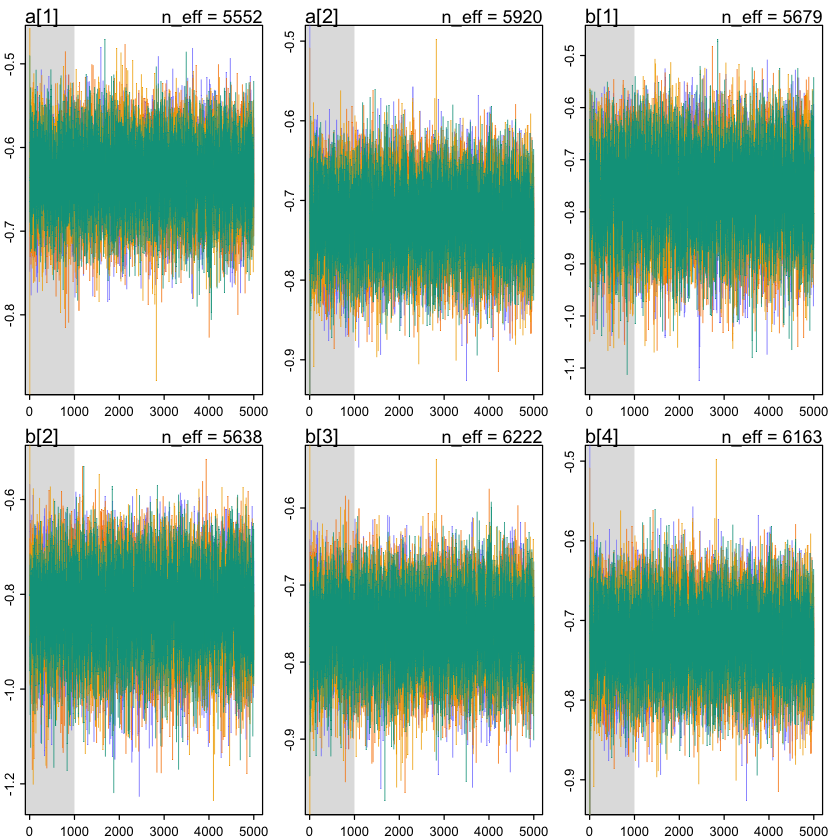

In [26]:
# Let's check the trace plots to see how our Markov chains did. No sign of 
traceplot(m11.4coin)

In [28]:
compare(m11.4pop_only, m11.4coin)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
m11.4pop_only,1679.280,1.979781,0.0000000,0.536972,2.821955,NA
m11.4coin,1679.576,3.922490,0.2963172,0.463028,4.555631,3.516115


In [ ]:
# If there were problems sampling, we can plot Stan's fitted-model output.
# If there were serious sampling problems, we'd see some very lopsided plots here,
# instead of round or slanted probability clouds.
pairs(m11.4coin@stanfit)